In [10]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [11]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

#### Import data into tensorflow dataset object

In [12]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
 shuffle=True,
 image_size=(IMAGE_SIZE,IMAGE_SIZE),
 batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [13]:
class_names=dataset.class_names
class_names


['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [14]:
len(dataset)

68

In [15]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 2 1 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 2 0 1 1 2 0 1 0 1 0 0]


### Visualize some of the images from our dataset

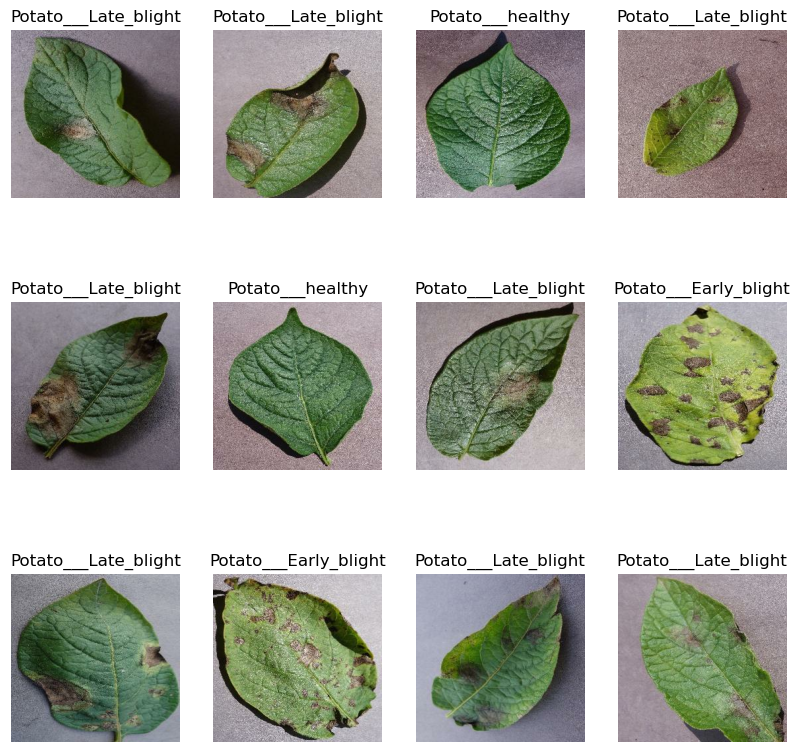

In [16]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in  dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

In [17]:
len(dataset)

68

In [18]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [19]:
train_ds = dataset.take(54)
len(train_ds)

54

In [20]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [21]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [22]:
val_ds=test_ds.skip(6)
len(val_ds)

8

In [23]:
def get_dataset_partitions_tf(ds,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds


In [24]:
 train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [25]:
len(train_ds)

54

In [26]:
len(val_ds)

6

In [27]:
len(test_ds)

8

#### Cache, Shuffle, and Prefetch the Dataset

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model
Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.



In [29]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the dat

In [30]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [31]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture
 CNN coupled with a Softmax activation in the output layer. add initial layers for resizing, normalization and Data Augmentation.

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the Model
 adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 107s 2s/step - loss: 0.8799 - accuracy: 0.5112 - val_loss: 0.7204 - val_accuracy: 0.6927
Epoch 2/50
54/54 [==============================] - 100s 2s/step - loss: 0.6467 - accuracy: 0.7130 - val_loss: 0.5127 - val_accuracy: 0.7969
Epoch 3/50
54/54 [==============================] - 99s 2s/step - loss: 0.4618 - accuracy: 0.8169 - val_loss: 0.4092 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 100s 2s/step - loss: 0.3368 - accuracy: 0.8656 - val_loss: 0.3230 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 99s 2s/step - loss: 0.2931 - accuracy: 0.8809 - val_loss: 0.2720 - val_accuracy: 0.8854
Epoch 6/50
54/54 [==============================] - 98s 2s/step - loss: 0.2317 - accuracy: 0.9079 - val_loss: 0.3796 - val_accuracy: 0.8438
Epoch 7/50
54/54 [==============================] - 98s 2s/step - loss: 0.2152 - accuracy: 0.9131 - val_loss: 0.1570 - val_accuracy: 0.9375
Epoch 8/50
54/54 

In [37]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 394ms/step - loss: 0.0671 - accuracy: 0.9883


#### Plotting the Accuracy and Loss Curves

In [38]:
history

In [39]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [40]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

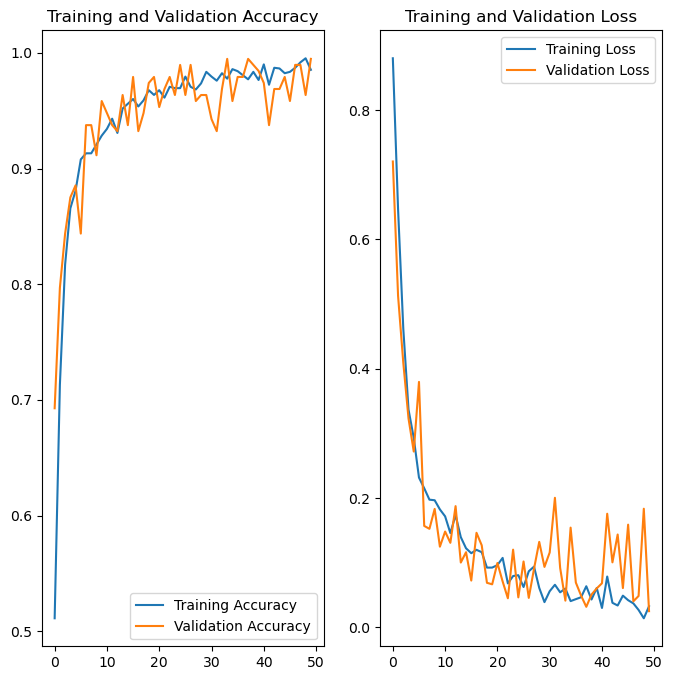

In [42]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


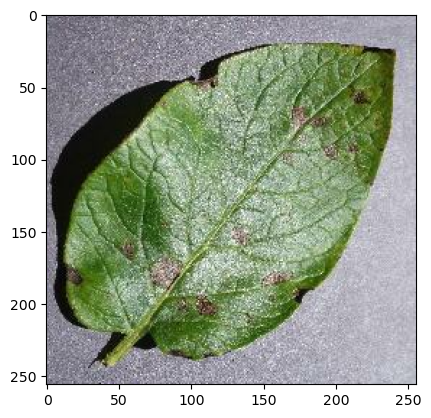

In [43]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


#### Function for inference

In [44]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 43ms/step


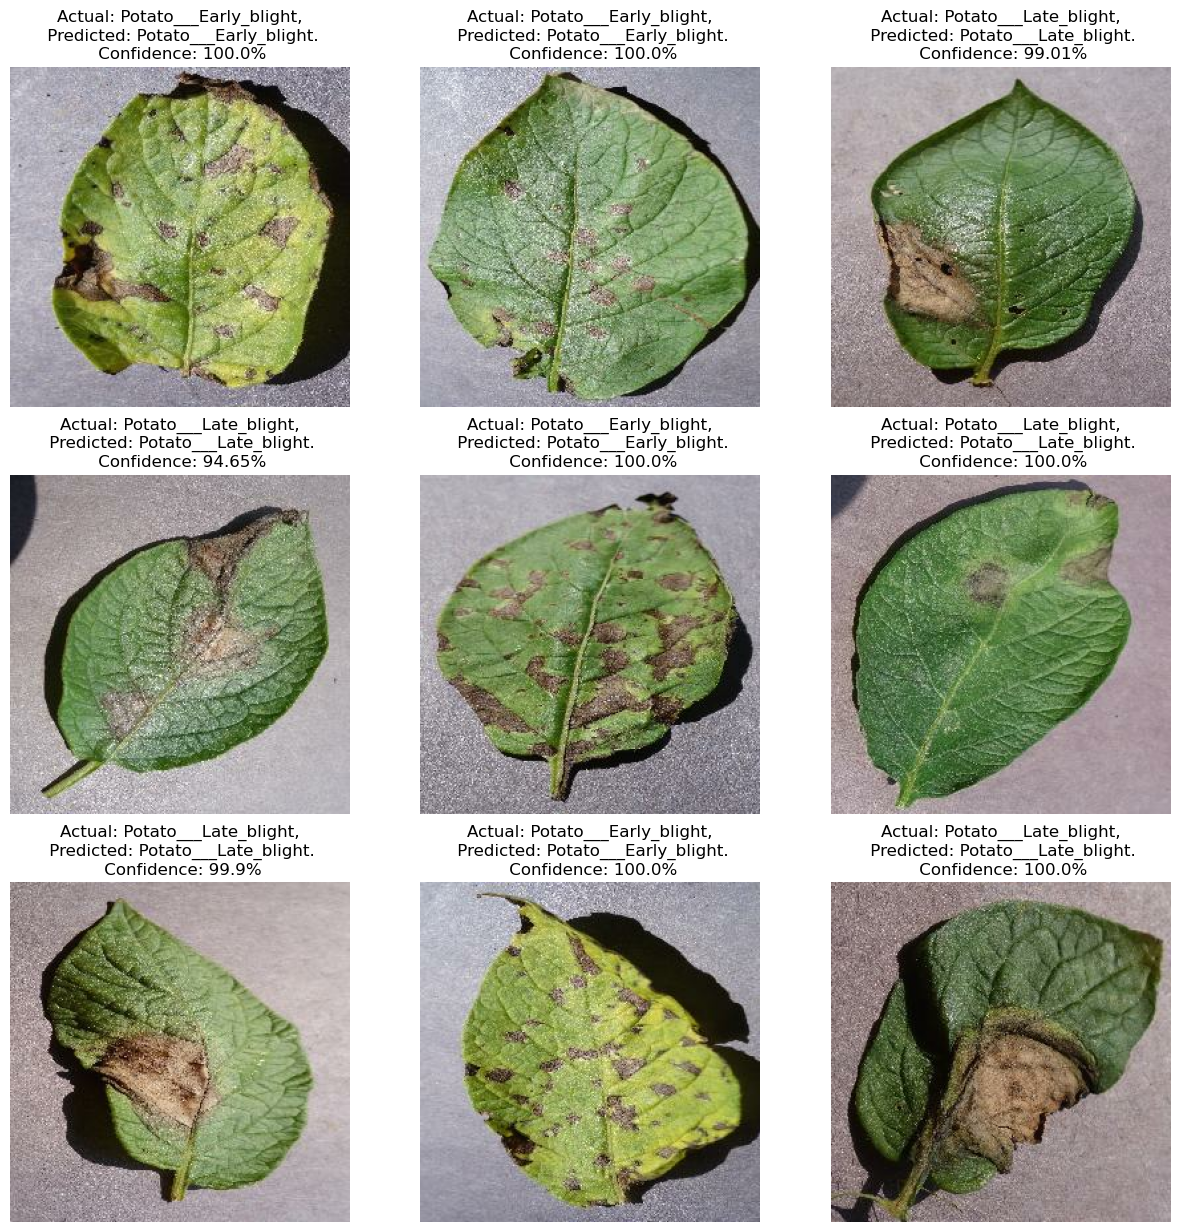

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving the Model
 append the model to the list of models as a new version

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")